# Towards Playing Full MOBA Games with Deep Reinforcement Learning

# 摘要
- self-play learning, policy distillation, off-policy adaption, multi-head value estimation, and Monte-Carlo tree-search

# 介绍
- 王者荣耀的复杂度
    - 状态和动作空间共$10^{20000}$， 对比围棋$10^{360}$
    - 再加上同一局中，不同英雄的不同实时策略(每个英雄有独立的玩法)
- SOTA: DeepMind团队的OpenAI Five，玩Dota 2 局限是仅仅支持17个英雄
- 规模化的问题：
    - 英雄池对RL影响，英雄增加，英雄的组合增加，DeepMind发现当英雄数达到25个时，训练速度不可接受
- 结构
    - 分布式RL架构
    - 统一的actor-critic 
    - multi-head value estimation 处理state-action对不确定
    - 先易后难，固定lineups来得到teacher model，蒸馏出policy
    - 应对英雄选择，蒙特卡洛搜索树
- 成果
    - 和专业队打: 42场胜率95.2%
    - 和王者打: 642047场 97.7% 
- 贡献
    - 提出AI learning paradigm
    - 历史上第一次采取大规模测试
    
# 相关工作
- 实时策略类游戏(Real-time strategy)
    - StarCraft 
    - SAIDA：韩国团队，基于规则的方法，手工编写规则，49702多行
    - AlphaStar：结合监督学习和多智能体强化学习
- MOBA游戏
    - Tencent Solo: 强化学习，只能打1v1
    - OpenAI Five： 强化学习和self-play采用了PPO算法。
    
# 方法

## 架构
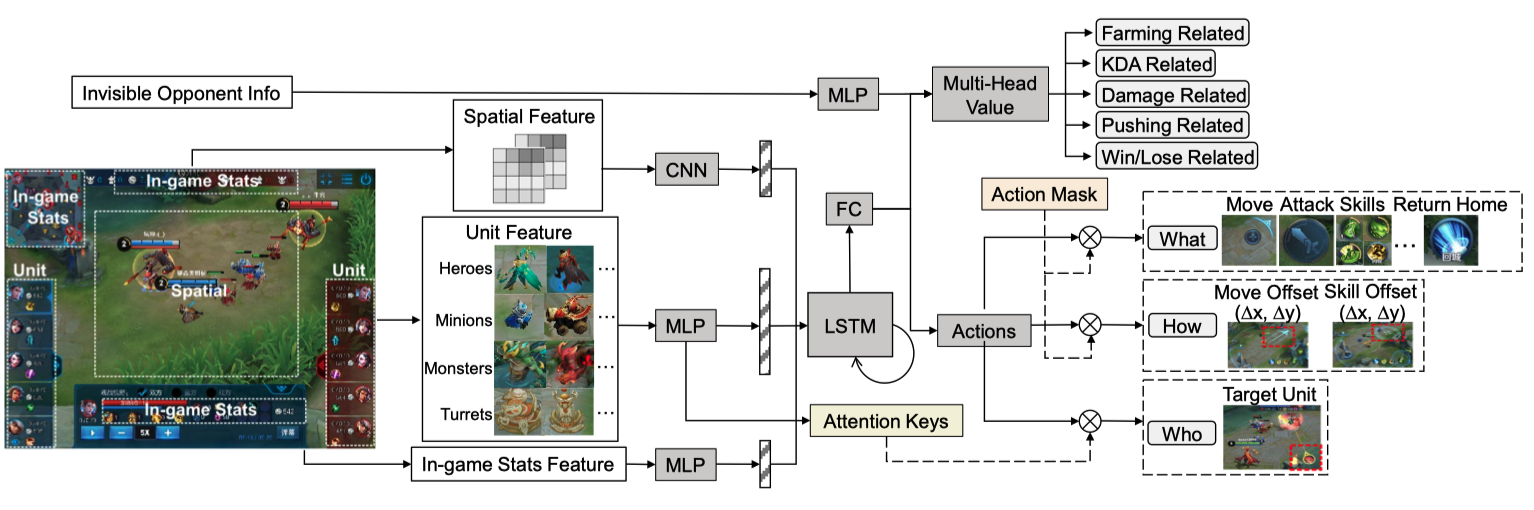

- Observation:
    - 标量信息
        - 包括不可见的对手信息: hp, skill cool down(技能冷却时间), gold, level
    - 空间信息
- LSTM 处理时间步之间的信息，记住过去的信息
- Target attention
    - LSTM后的作为Query， unit feature（英雄，怪，龙，塔，即所有单位）作为key
- Aciton mask: 去除没有必要的强化学习探索
    - 物理上到不了的区域
    - 没有冷却的技能
    - 被控住不能动
    - 其它特别的限制
- Hierarchical action heads and discretize each head
    - 动机：处理爆炸的动作空间
    - AI按照层级进行动作预测：
        1. 动作：移动，攻击，技能，回家
        2. 目标：塔，敌人，小怪
        3. 动作幅度：移动的位移，技能的位移等

## 强化学习

- policy function updates:
    - 动机之一：降低方差
    - Dual-clip PPO: 结合下面的图直观理解，就是控制反向传播前，计算出的loss不要太大。因为，如果loss太大，会让策略发生巨大变动，不利于收敛。
        - 相对于原来的clip PPO只截断一侧，dual-clip PPO将两侧都截断，很好控制了loss变化幅度，结合下图和公式来看
            - 原先的clip方法，当A>0时，能够很好控制住L不会过大，可是当A小于0时，L可以变成负无穷，这不是我们想要的
            - dual-clip方法，则又引入了c(c>1)，这样，在第一次截断，取了min之后，又通过max操作，让可能出现的负无穷和cA相比，取较大的。这就解决了原本存在的负无穷问题
    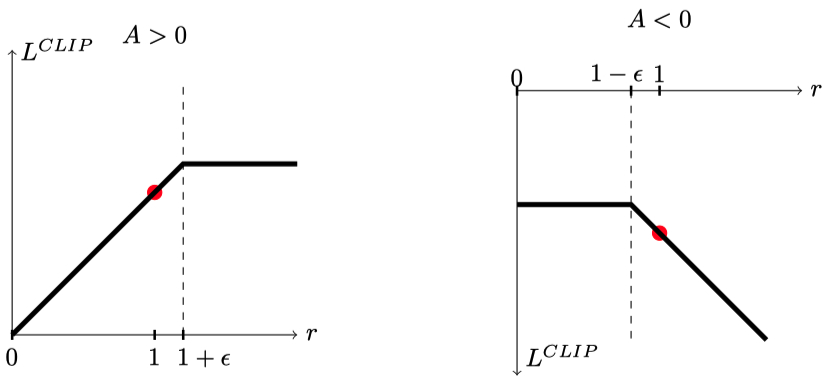
    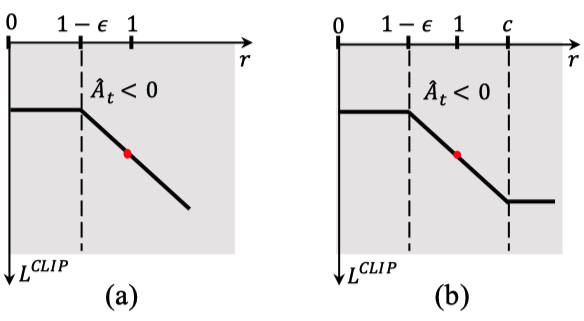
    
$$
\mathcal{L}^{\text {policy}}(\theta)=\mathbb{E}_{t}\left[\max \left(\min \left(r_{t}(\theta) \hat{A}_{t}, \operatorname{clip}\left(r_{t}(\theta), 1-\epsilon, 1+\epsilon\right) \hat{A}_{t}\right), c \hat{A}_{t}\right)\right]
$$
    
- value function updates:
    - 动机之一：降低方差
    - MHV(multi head value)，设置了5类reward
        1. Farming related: 钱，经验，法力...
        2. KDA relatd: 人头，死亡，助攻，buff，补刀...
        3. Damage related：HP，伤害
        4. Pushing related: 推塔，推基地
        5. win/loss related: 摧毁基地
    - value 的 losss
$$
\mathcal{L}^{\text {value}}(\theta)=\mathbb{E}_{t}\left[\sum_{\text {head}_{k}}\left(R_{t}^{k}-\hat{V}_{t}^{k}\right)^{2}\right], \quad \hat{V}_{t}=\sum_{\text {head}_{k}} w_{k} \hat{V}_{t}^{k}
$$

## 多智能体训练
- self-replay
    - 模型自己收集经验、学习，不需要监督信息。比如actor-critic
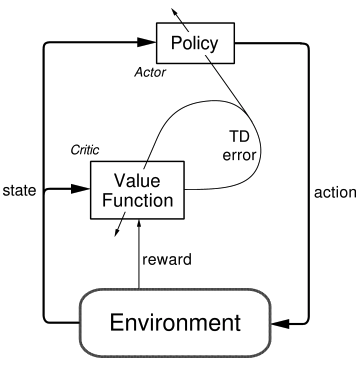
- Curriculum learning
- 提出Curriculum self-play learning (CSPL)
    - Curriculum: A curriculum is all the different courses of study that are taught in a school, college, or university.
- 图示
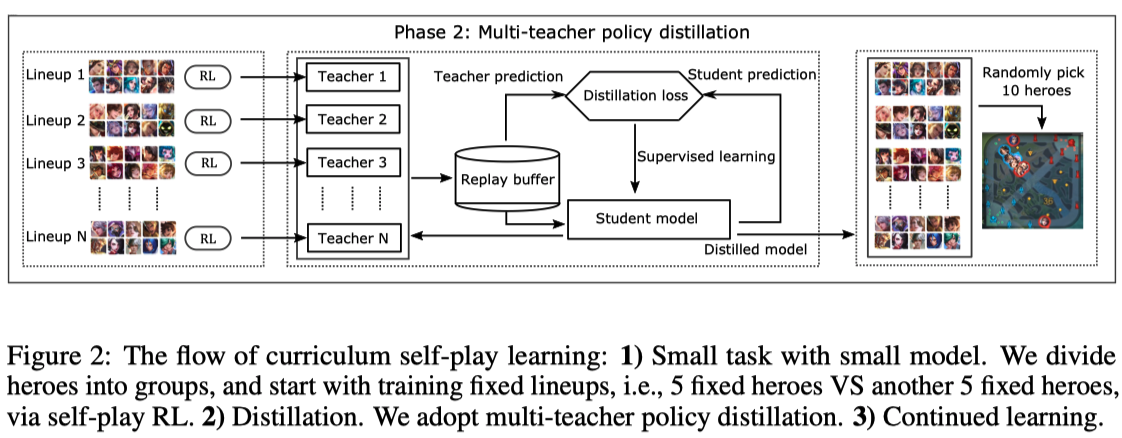
- 三阶段
    - 1 Small task with small model
        - 训小模型。40个英雄，分成四组每组10个，**固定住**。在10个英雄中，根据现实游戏中每个英雄真实的历史胜率划分，让两队的胜率都接近50%。这样做认为更有利于self-play，后面用于生成训练集，训练英雄选择模型
        - 被训的模型称为teacher.它在之后会student利用。训teacher用的参数是最终模型的一半
    - 2 Distillation
        - 学生模型通过蒸馏第一阶段中的多个老师模型基于固定的policy和value函数学习出一个新模型
        - 蒸馏的loss具体公式如下：分别对每个policy和value对应的交叉熵和均方损失求期望再求和      
$$
\mathcal{L}^{\text {distil}}(\theta)=\sum_{\text {teacher}_{i}} \hat{\mathbb{E}}_{\pi_{\theta}}\left[\sum_{t} H^{\times}\left(\pi_{i}\left(s_{t}\right) \| \pi_{\theta}\left(s_{t}\right)\right)+\sum_{\text {head}_{k}}\left(\hat{V}_{i}^{k}\left(s_{t}\right)-\hat{V}_{\theta}^{k}\left(s_{t}\right)\right)^{2}\right]
$$
    - 3 Continued learning
        - 在之前蒸馏好的模型基础上，从英雄池中选用不同的阵容来进行训练

## 开局选英雄模型
- 选英雄的过程MCTS(蒙特卡洛搜索树)
    - 最大的问题，simulation 那步需要打游戏，速度太慢
- 方法
    - 构建数据集。self-play生成很多场真实比赛
    - 训练胜率预测器
        - 给定双方阵容，预测比赛获胜的概率$[0,1]$
        - 在训练好后，将预测器预测结果作为监督信号，用来后面的状态价值预测器用。
    - 状态价值预测器value network. 
        - 给定某个状态(某个结点），预测这个状态的价值。具体输入为 (当前阵容，未选择的英雄，当前正在选择的队伍)

## 基础架构
- Actor-Learner架构
    - Learner 用GPU训练策略网络
    - Actotr 用CPU进行self-play，多核多actor，将一系列的(状态，动作，奖励）对异步传给Learner训练
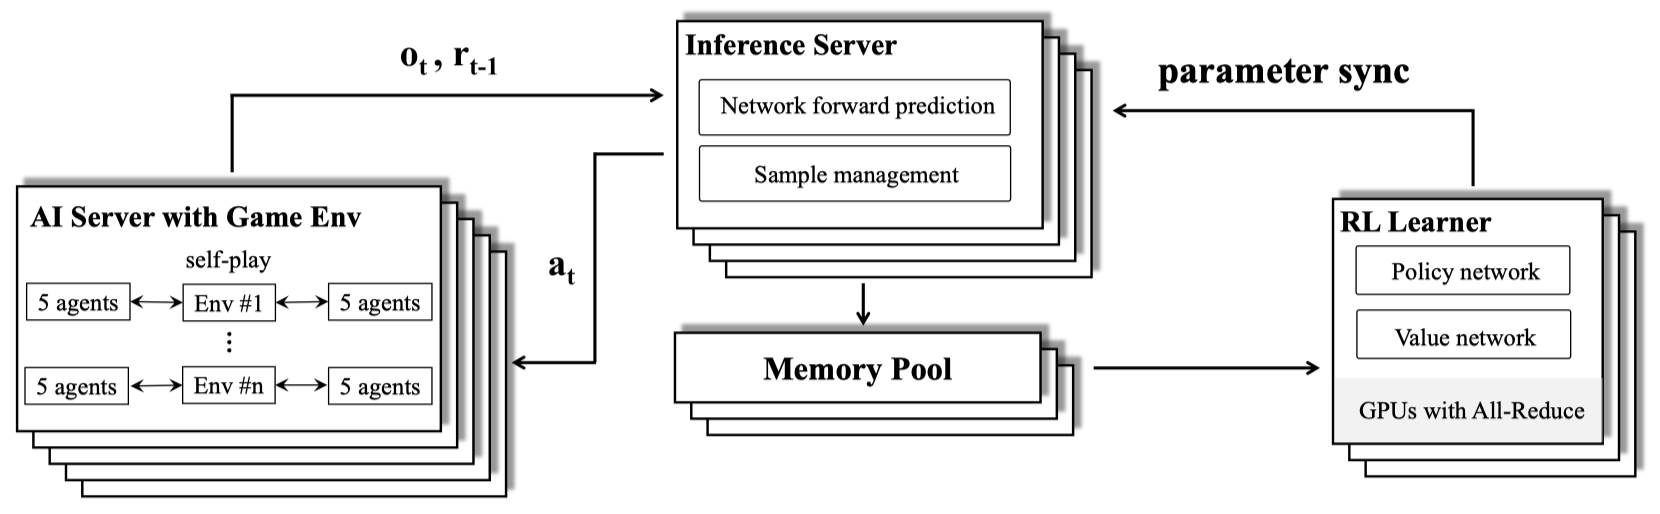
# 实验
- 和顶级选手，42场，赢40
- 和王者 642,047场胜率97.7%


## 训练过程
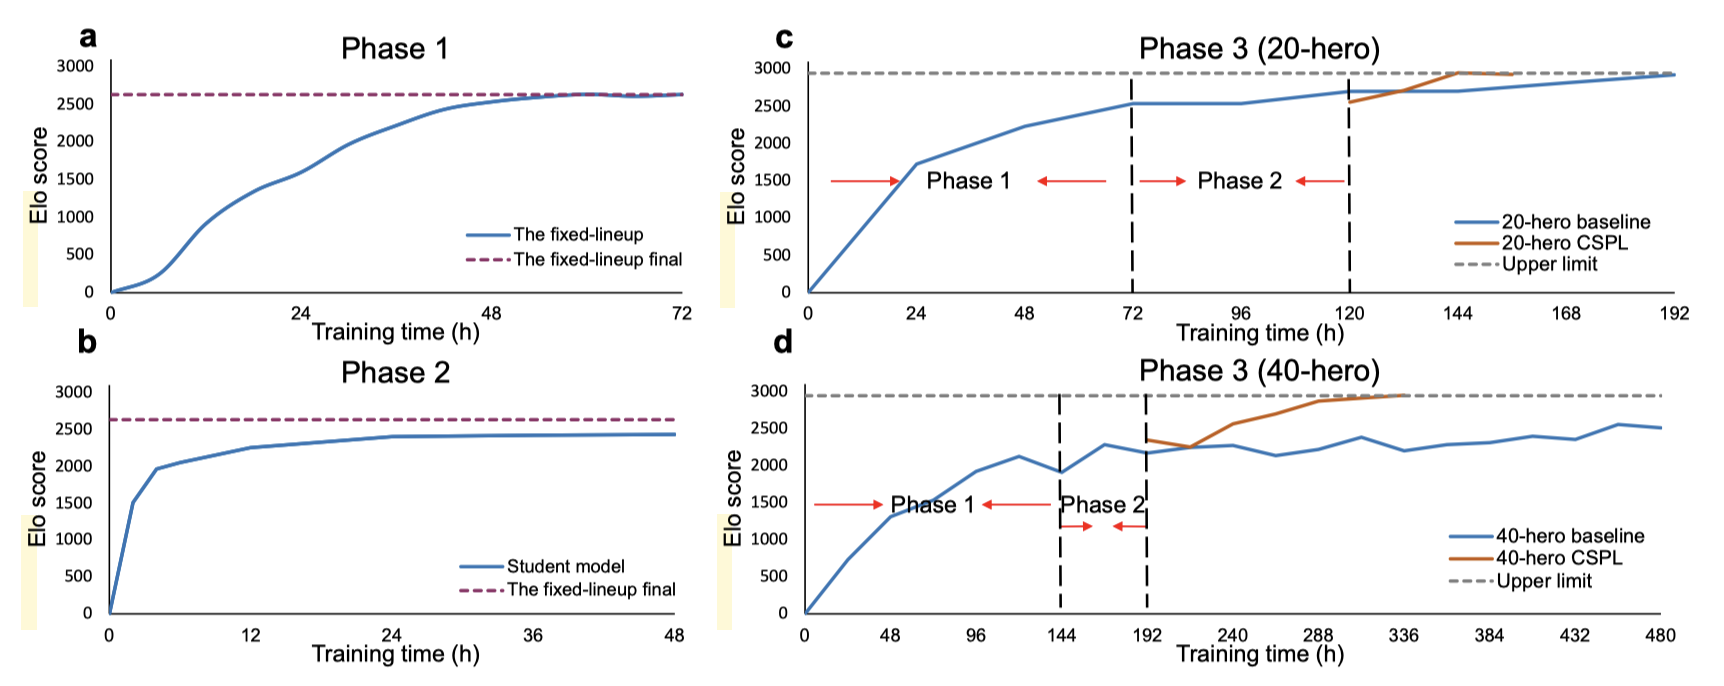
- baseline：DeePAI Five
- 随着英雄池规模增加，CSPL算法效果更明显
- teacher-student 蒸馏的作用明显
## 训练用时
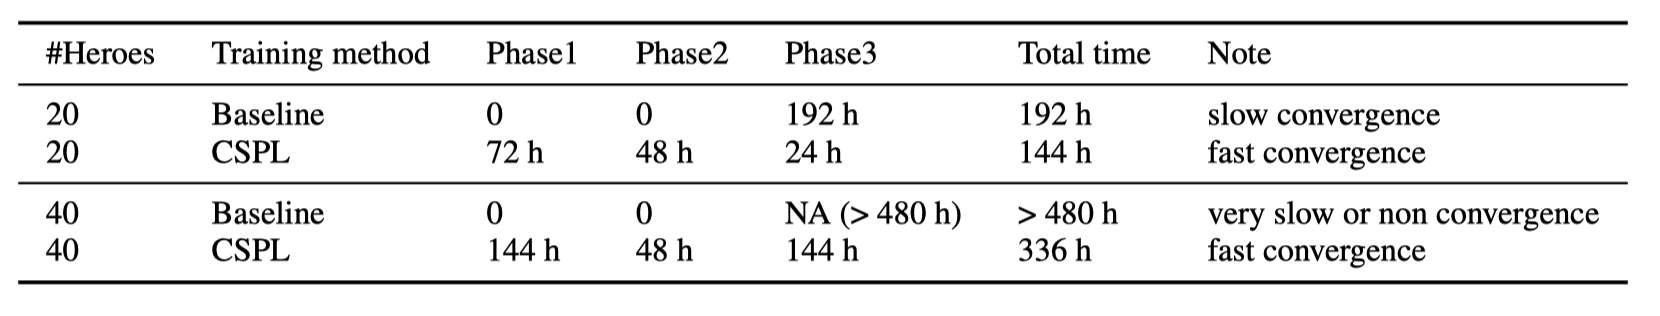
## 消融实验
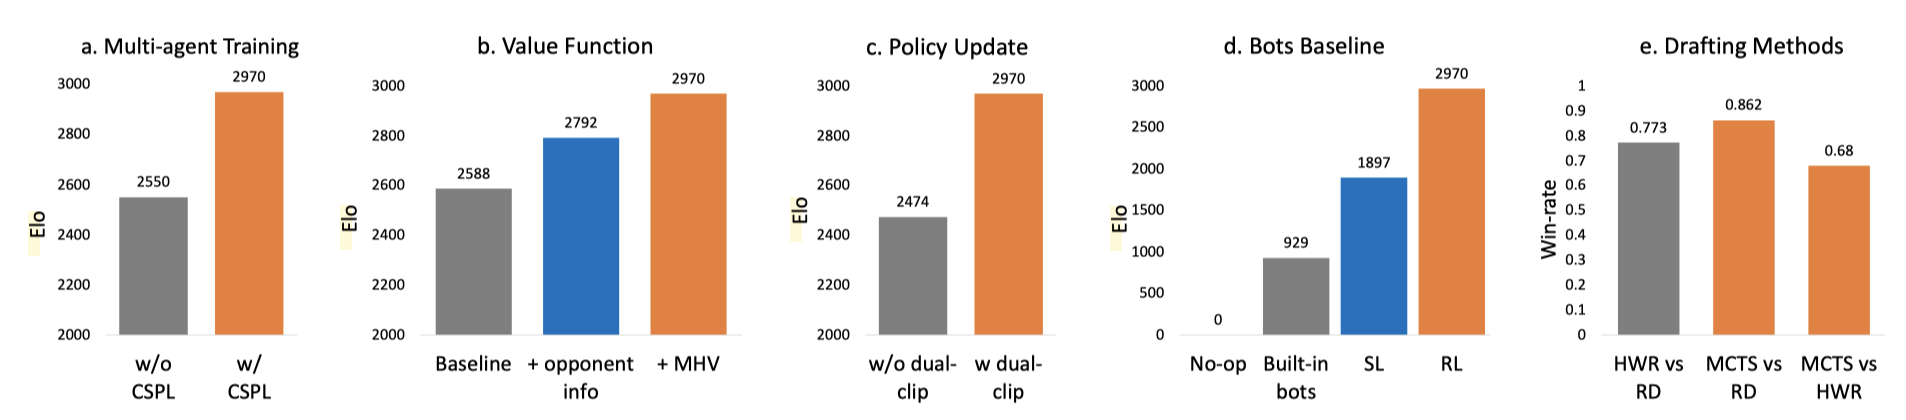



# 附录

## 1 动作空间
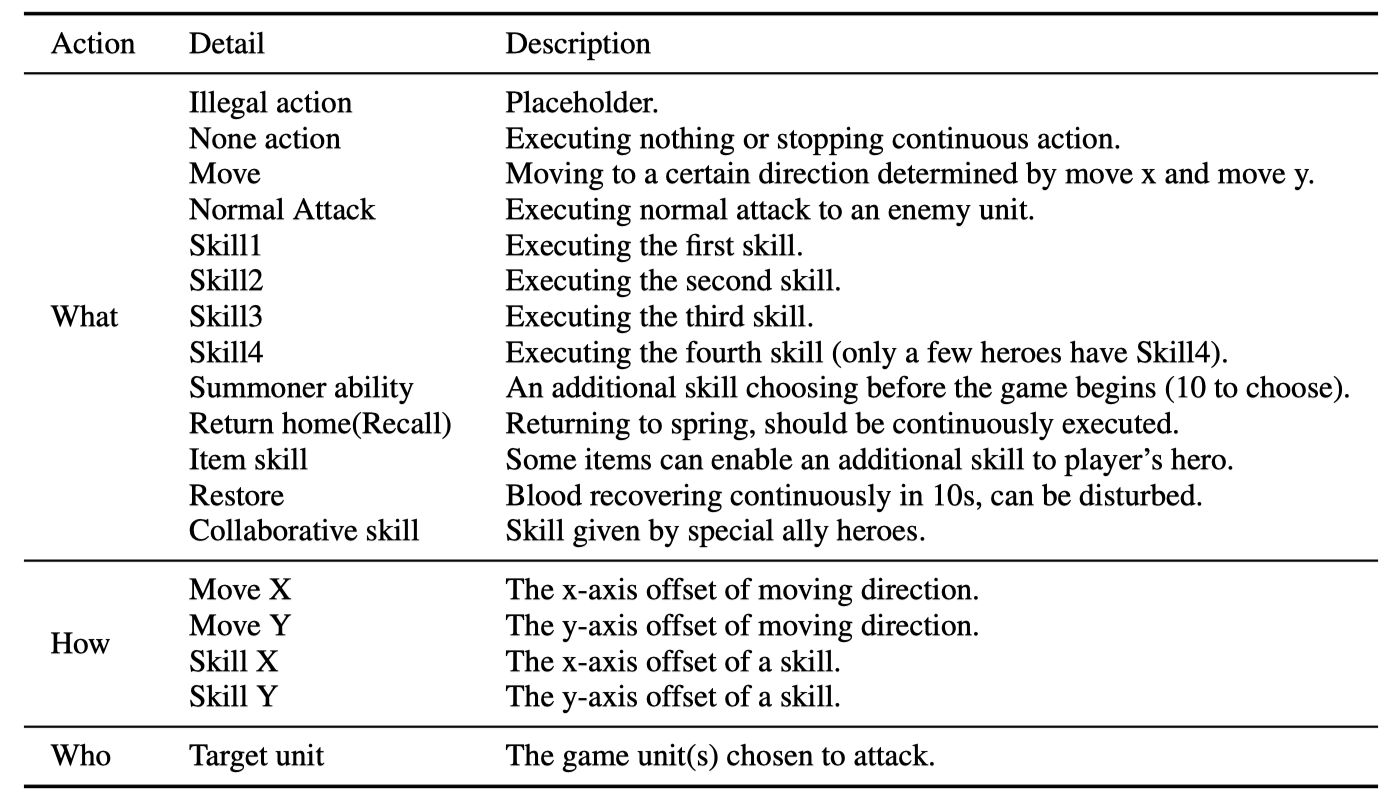
## 2 奖励设计
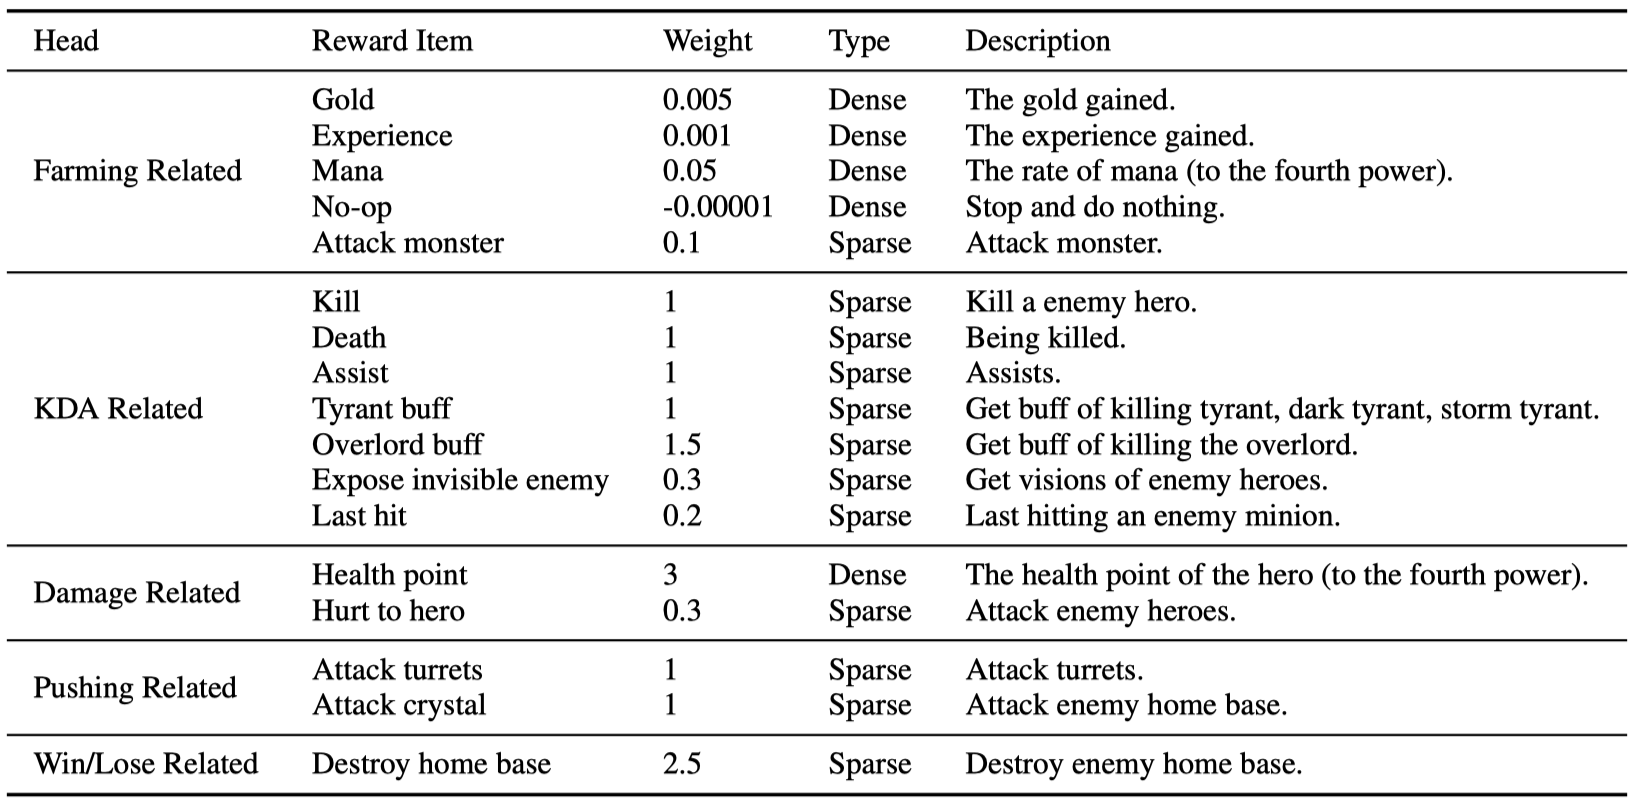
## 3 特征细节
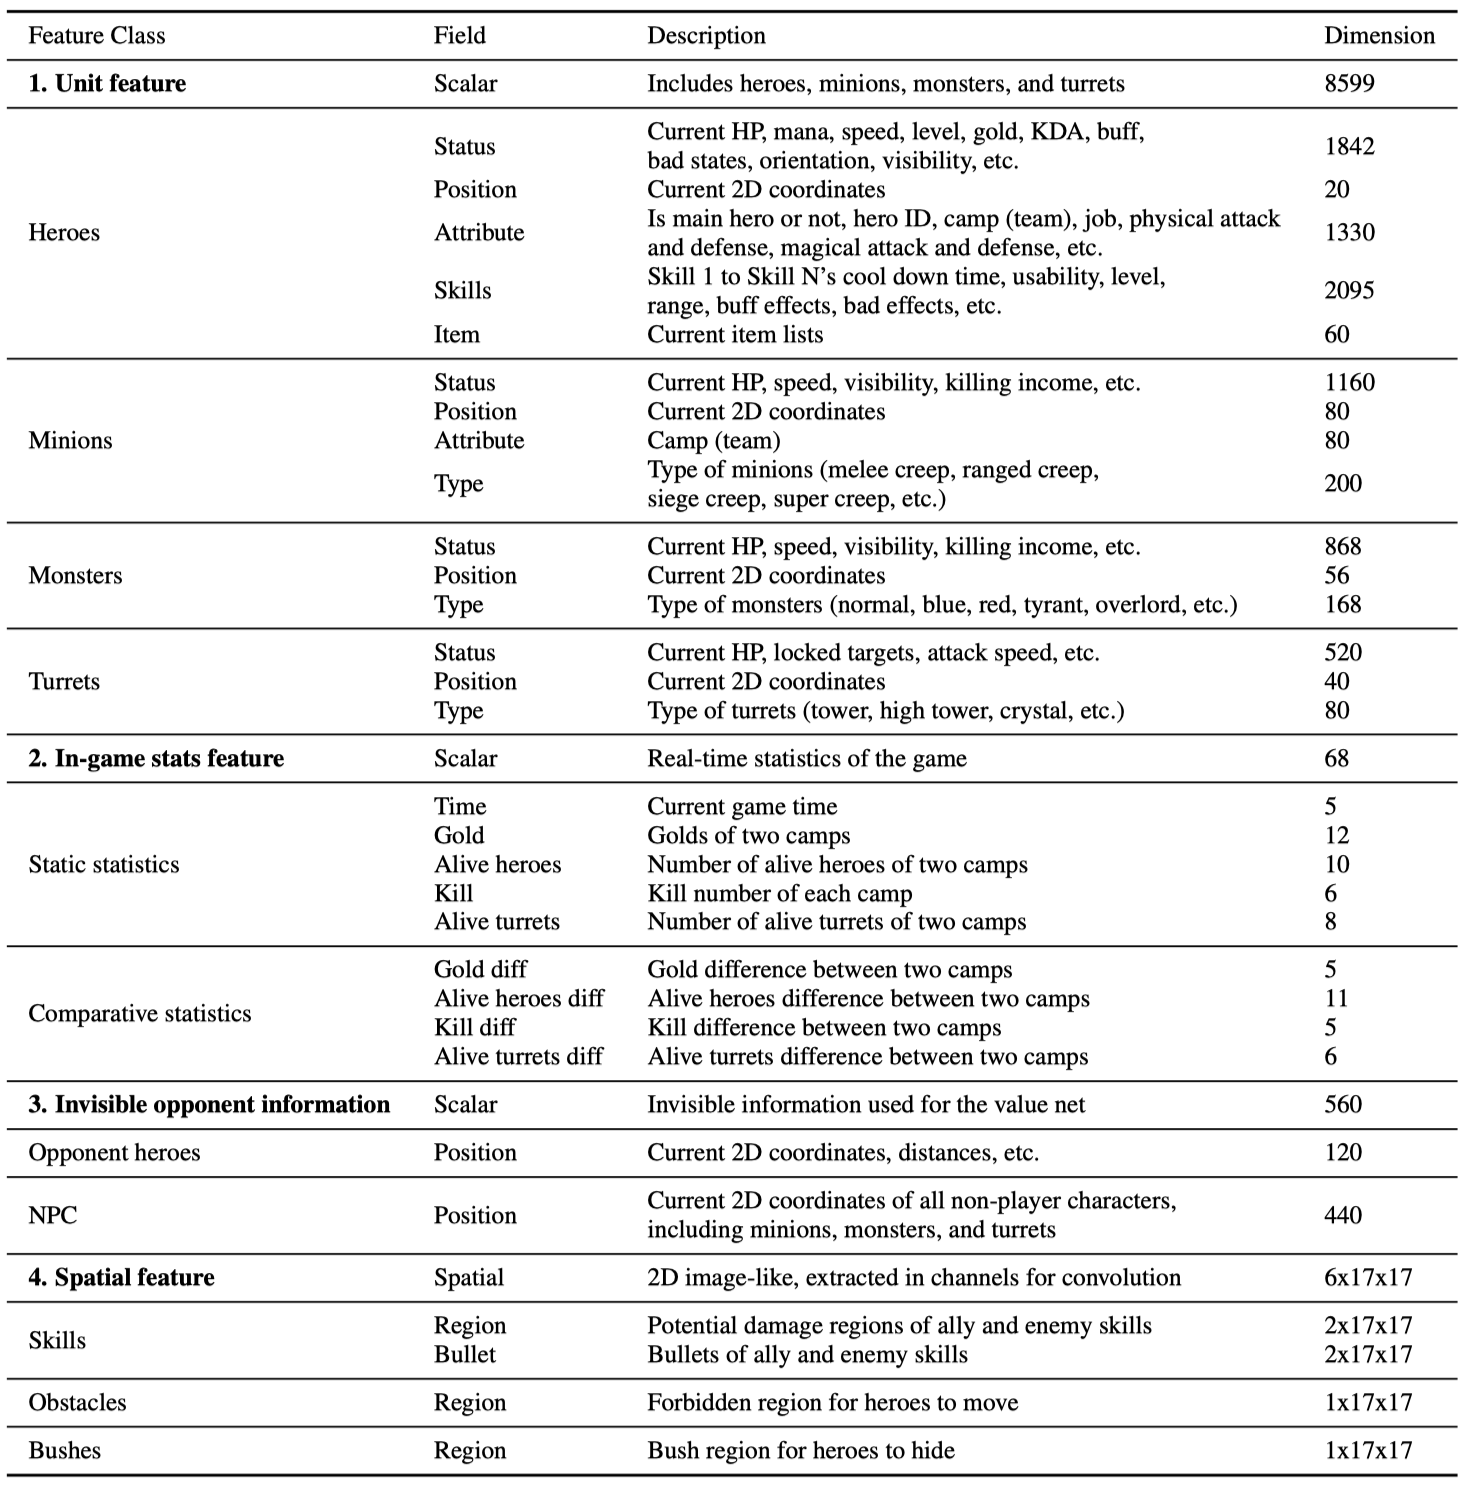
## 4 蒙特卡洛搜索树
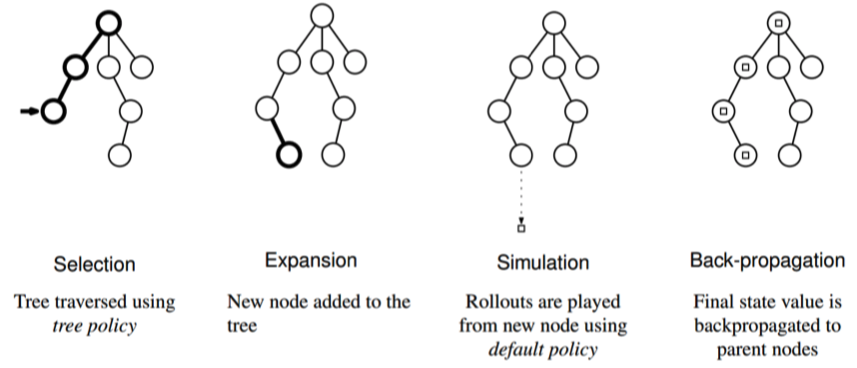